In [44]:
import random
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pyoptinterface as poi
from pyoptinterface import highs
import networkx as nx

In [45]:
#Turn random node generation on/off
RANDOM_NODES = True
NUM_NODES = 75

#Turn subtour elimination constraints on/off
ADD_SUBTOUR_CONSTRAINTS = True

#Turn Seed for deterministic  runtime on/off
USE_SEED = True
SEED = 12345

In [46]:
if USE_SEED:
    random.seed(SEED)

In [47]:
def generate_nodes(num_nodes: int):
    nodes = num_nodes
    edges = list(combinations(range(nodes), 2))

    coord = {
        n: (random.randint(0, 100), random.randint(0, 100)) for n in range(nodes)
    }

    dist = {
        (n, m): int(np.sqrt(
            (coord[n][0] - coord[m][0]) ** 2
            + (coord[n][1] - coord[m][1]) ** 2
        ))
        for (n, m) in edges
    }

    return nodes, edges, dist, coord

In [48]:
#Generate/read Nodes
if RANDOM_NODES:
    nodes, edges, dist, coord = generate_nodes(NUM_NODES)
else:
    # TODO read nodes
    print("read from graph")

In [49]:
# Optimization model
model = highs.Model()

In [50]:
# Decision variable
x = model.add_variables(edges, domain=poi.VariableDomain.Binary)

In [51]:
# constraint : leave and enter each node only once
for n in range(nodes):
    model.add_linear_constraint(
        poi.quicksum(x[n, v] for v in range(nodes) if (n, v) in edges) +
        poi.quicksum(x[v, n] for v in range(nodes) if (v, n) in edges) , poi.Eq, 2)

In [52]:
obj = poi.quicksum(dist[e] * x[e] for e in edges)
model.set_objective(obj, poi.ObjectiveSense.Minimize)

In [53]:
model.optimize()

In [54]:
def compute_cycles(x, nodes) -> list[list]:
    graph = nx.Graph()
    graph.add_nodes_from(range(nodes))
    edges_used = [e for e in x if model.get_variable_attribute(x[e], poi.VariableAttribute.Value) > 0.99]

    graph.add_edges_from(edges_used)
    cycles = nx.minimum_cycle_basis(graph)
    return cycles

In [55]:
if ADD_SUBTOUR_CONSTRAINTS:
    cycles = compute_cycles(x, nodes)

    n_se_constrs = 0

    print (nodes)
    while len(cycles[0]) < nodes:
        for cycle in cycles:
            cycle = sorted(cycle)
            model.add_linear_constraint(
            poi.quicksum(x[u, v] for (u, v) in combinations(cycle, 2)) , poi.Leq, len(cycle) - 1)

        model.optimize()
        n_se_constrs += 1
        cycles = compute_cycles(x, nodes)


75


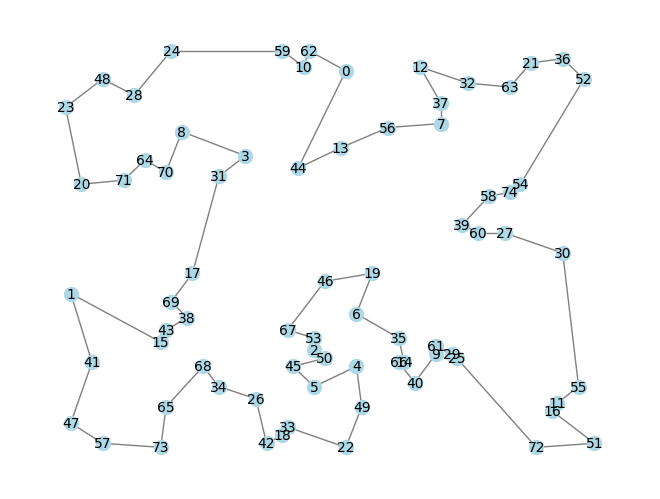

In [56]:
# Visualize results using networkx
fig = plt.figure()
G = nx.Graph()
for n in range(nodes):
    G.add_node(n, pos=coord[n])

edges_used = [e for e in x if model.get_variable_attribute(x[e], poi.VariableAttribute.Value) > 0.99]
G.add_edges_from(edges_used)
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=100, font_size=10)
plt.show()